In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix

from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def scale_min_max_features(Features, scaling_cols):
    scaler = MinMaxScaler()
    for col in scaling_cols:
        Features[col] = scaler.fit_transform(Features[[col]])
    return Features

def scale_standard_features(Features, scaling_cols):
    scaler = StandardScaler()
    for col in scaling_cols:
        Features[col] = scaler.fit_transform(Features[[col]])
    return Features


In [3]:
import numpy as np

class LogisticRegressionFromScratch:
    def __init__(self, learning_rate=0.01, max_iter=1000, regularization_strength=0.01):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.regularization_strength = regularization_strength
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, y, y_pred):
        m = len(y)
        regularization_term = self.regularization_strength / (2 * m) * np.sum(np.square(self.weights))
        return -1/m * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) + regularization_term

    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0

        print(self.weights.shape)

        for i in range(self.max_iter):
            # Forward pass
            z = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(z)
            
            # Gradient 
            dw = 1/m * np.dot(X.T, (y_pred - y)) + (self.regularization_strength / m) * self.weights
            db = 1/m * np.sum(y_pred - y)
            
            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Compute loss for monitoring
            if i % 100 == 0:
                loss = self.compute_loss(y, y_pred)
                # print(f"Iteration {i}: Loss = {loss}")

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(z)
        return np.array([1 if i > 0.5 else 0 for i in y_pred])

In [4]:

class BaggingLogisticRegression:
    def __init__(self, base_model, n_estimators=9):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.models = []

    def fit(self, X, y):
        self.models = []
        for _ in range(self.n_estimators):
            # Weak resampled bags
            X_resampled, y_resampled = resample(X, y)
            model = self.base_model.__class__(learning_rate=self.base_model.learning_rate, max_iter=self.base_model.max_iter)
            # Train the model on the bootstrap sample
            model.fit(X_resampled, y_resampled)
            self.models.append(model)

    def predict(self, X):
        predictions = np.zeros((X.shape[0], self.n_estimators))
        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict(X)
        # Majority vote
        final_predictions = np.round(np.mean(predictions, axis=1)).astype(int)
        return predictions,final_predictions

    def predict_all(self, X):
        # Get predictions from all models
        all_predictions = []
        for model in self.models:
            all_predictions.append(model.predict(X))# I amd doing it from the actual LR model
        return np.array(all_predictions)

In [5]:

# Performance Metrics Calculation
def get_performance_metrics(Y_test, Y_pred):
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1=f1_score(Y_test, Y_pred)
    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
    specificity = tn / (tn + fp)
    auroc=roc_auc_score(Y_test, Y_pred)
    aupr=average_precision_score(Y_test, Y_pred)

    return accuracy,recall,specificity,precision,f1,auroc,aupr    
    

# Violin Plot for Bagging Models
def plot_violin(models, X_test, y_test):
    metrics = []
    for model in models:
        y_pred = model.predict(X_test)
        metrics.append(get_performance_metrics(y_test, y_pred))

    metrics = np.array(metrics)
    metric_names = ["Accuracy", "Sensitivity", "Specificity", "Precision", "F1-Score", "AUROC", "AUPR"]

    for i, metric_name in enumerate(metric_names):
        plt.figure(figsize=(8,6))
        plt.xticks(rotation=45)
        sns.violinplot(data=metrics[:, i].reshape(-1, 1))
        plt.title(f"Violin Plot for {metric_name} across Bagging Models")
        plt.show()


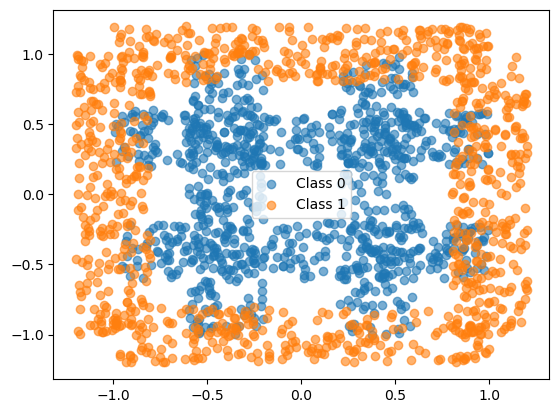

In [6]:

# load the dataset
df= pd.read_csv('concentric_squares_dataset.csv')
# print(df)
X = df[['X1', 'X2']].values
y = df['y'].values

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the dataset (optional for visualization)
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label='Class 0', alpha=0.6)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Class 1', alpha=0.6)
plt.legend()
plt.show()

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)




Logistic Regression Accuracy: 0.52
Logistic Regression Sensitivity: 0.50
Logistic Regression Specificity: 0.54
Logistic Regression Precision: 0.51
Logistic Regression F1-Score: 0.51
Logistic Regression AUROC: 0.52
Logistic Regression AUPR: 0.50
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(9, 7)
Bagging Logistic Regression Accuracy: 0.53 ± 0.05
Bagging Logistic Regression Sensitivity: 0.47 ± 0.09
Bagging Logistic Regression Specificity: 0.59 ± 0.17
Bagging Logistic Regression Precision: 0.55 ± 0.06
Bagging Logistic Regression F1-Score: 0.49 ± 0.04
Bagging Logistic Regression AUROC: 0.53 ± 0.05
Bagging Logistic Regression AUPR: 0.51 ± 0.03
(400, 9)
(9, 400)
Voting Ensemble Accuracy: 0.54
Voting Ensemble Sensitivity: 0.42
Voting Ensemble Specificity: 0.66
Voting Ensemble Precision: 0.54
Voting Ensemble F1-Score: 0.47
Voting Ensemble AUROC: 0.54
Voting Ensemble AUPR: 0.51
(320, 9)
(320, 11)
Meta Model Accuracy: 0.70
Meta Model Sensitivity: 0.75
Meta Model Specificity: 0.67
Meta Model Prec

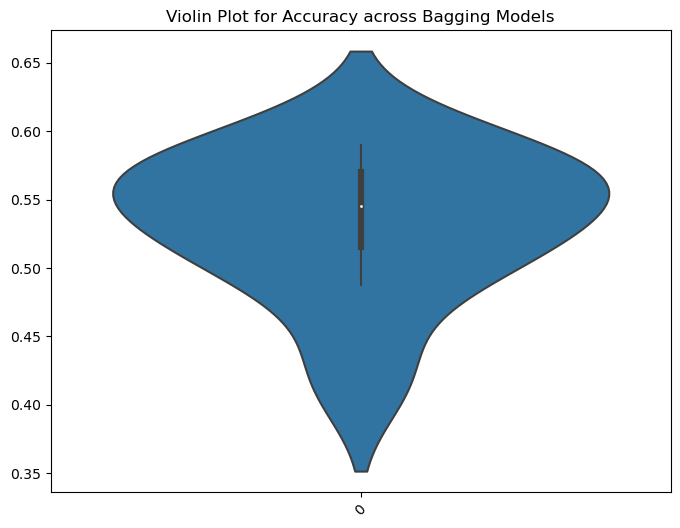

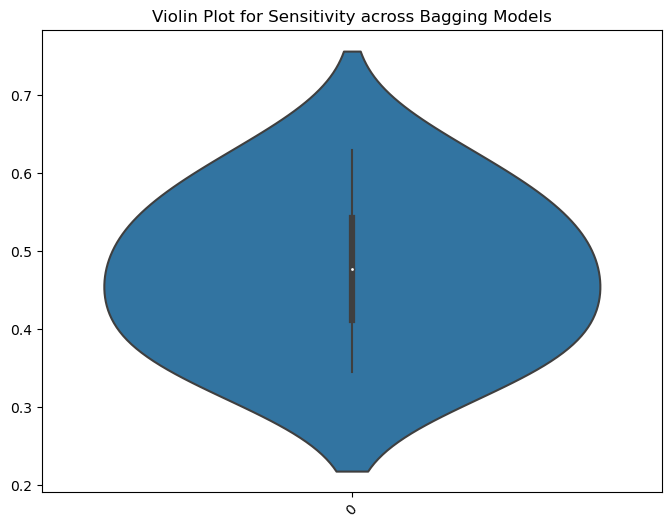

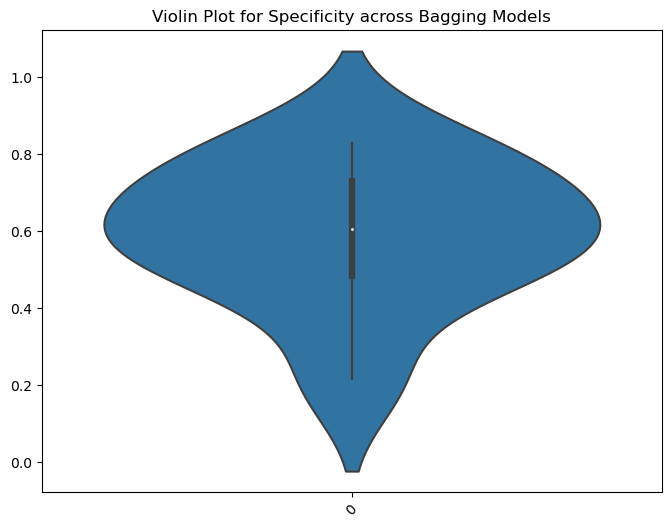

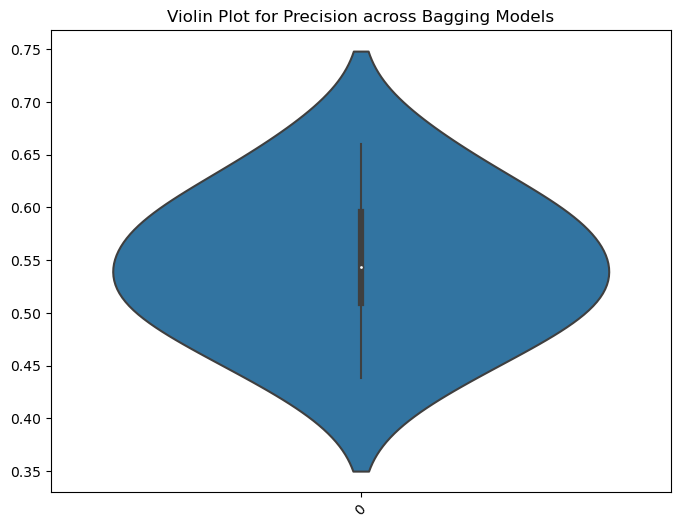

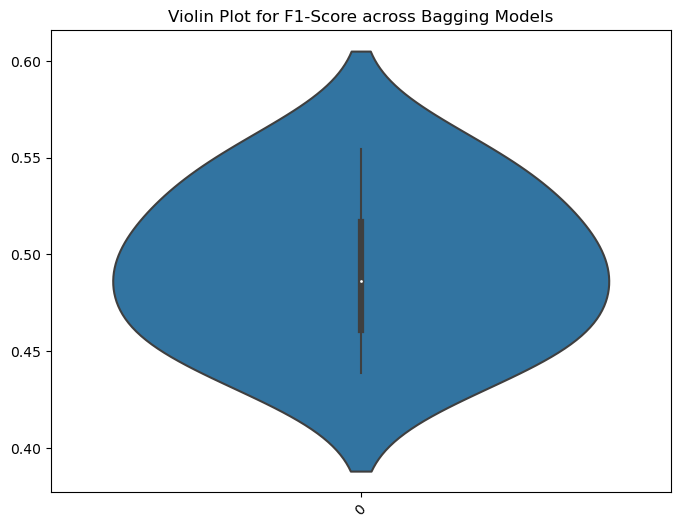

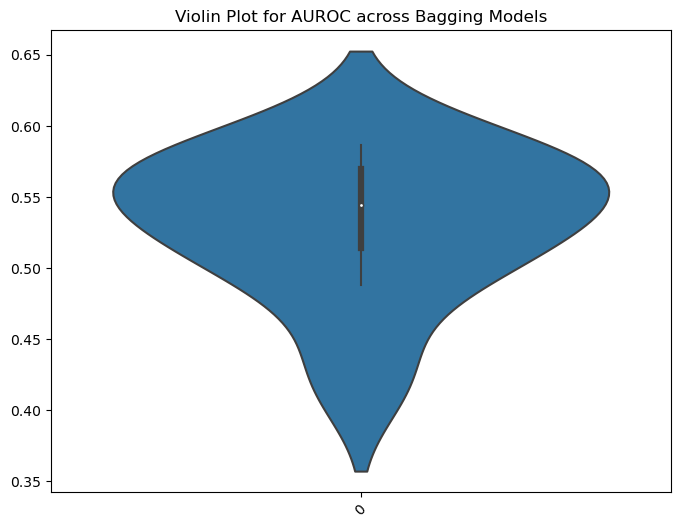

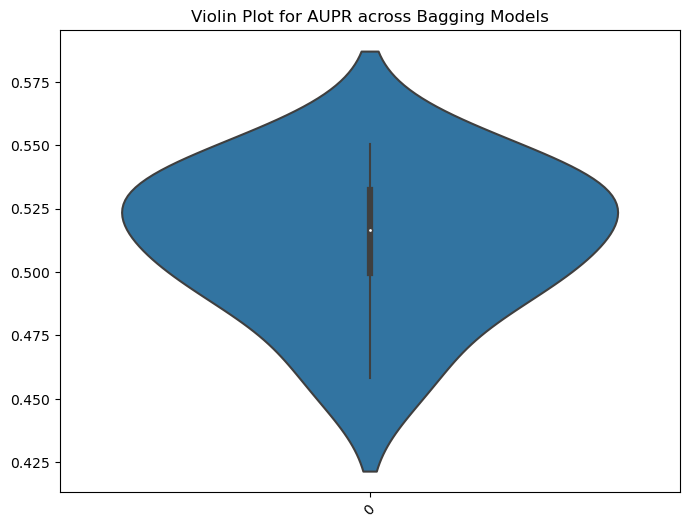

In [7]:
report_data = []

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, Y_train)
Y_pred = log_model.predict(X_test)

metrics = get_performance_metrics(Y_test, Y_pred)
report_data.append(["Logistic Regression"] + list(metrics))

print(f"Logistic Regression Accuracy: {metrics[0]:.2f}")
print(f"Logistic Regression Sensitivity: {metrics[1]:.2f}")
print(f"Logistic Regression Specificity: {metrics[2]:.2f}")
print(f"Logistic Regression Precision: {metrics[3]:.2f}")
print(f"Logistic Regression F1-Score: {metrics[4]:.2f}")
print(f"Logistic Regression AUROC: {metrics[5]:.2f}")
print(f"Logistic Regression AUPR: {metrics[6]:.2f}")


base_model = LogisticRegressionFromScratch(max_iter=1000)

bagging_model = BaggingLogisticRegression(base_model=base_model, n_estimators=9)


bagging_model.fit(X_train, Y_train)


test_predictions_col,Y_pred_bagging = bagging_model.predict(X_test)

all_metrics=[]
# Get predictions from all 9 models
test_predictions = bagging_model.predict_all(X_test)
for prediction in test_predictions:
    all_metrics.append(get_performance_metrics(Y_test, prediction))

all_metrics = np.array(all_metrics)
print(all_metrics.shape)

average_metrics = np.mean(all_metrics, axis=0)
std_metrics = np.std(all_metrics, axis=0)

metrics = get_performance_metrics(Y_test, Y_pred_bagging)
report_data.append(["LR*"] + list(average_metrics +  std_metrics))


print(f"Bagging Logistic Regression Accuracy: {average_metrics[0]:.2f} ± {std_metrics[0]:.2f}")
print(f"Bagging Logistic Regression Sensitivity: {average_metrics[1]:.2f} ± {std_metrics[1]:.2f}")
print(f"Bagging Logistic Regression Specificity: {average_metrics[2]:.2f} ± {std_metrics[2]:.2f}")
print(f"Bagging Logistic Regression Precision: {average_metrics[3]:.2f} ± {std_metrics[3]:.2f}")
print(f"Bagging Logistic Regression F1-Score: {average_metrics[4]:.2f} ± {std_metrics[4]:.2f}")
print(f"Bagging Logistic Regression AUROC: {average_metrics[5]:.2f} ± {std_metrics[5]:.2f}")
print(f"Bagging Logistic Regression AUPR: {average_metrics[6]:.2f} ± {std_metrics[6]:.2f}")



print(test_predictions_col.shape)
print(test_predictions.shape)


metrics = get_performance_metrics(Y_test, Y_pred_bagging)
report_data.append(["Voting ensemble"] + list(metrics))


print(f"Voting Ensemble Accuracy: {metrics[0]:.2f}")
print(f"Voting Ensemble Sensitivity: {metrics[1]:.2f}")
print(f"Voting Ensemble Specificity: {metrics[2]:.2f}")
print(f"Voting Ensemble Precision: {metrics[3]:.2f}")
print(f"Voting Ensemble F1-Score: {metrics[4]:.2f}")
print(f"Voting Ensemble AUROC: {metrics[5]:.2f}")
print(f"Voting Ensemble AUPR: {metrics[6]:.2f}")

validation_predictions_col,Y_val_pred = bagging_model.predict(X_val)
print(validation_predictions_col.shape)

if validation_predictions_col.ndim == 1:
    validation_predictions_col = validation_predictions_col.reshape(-1, 1)

# Concatenate X_val and validation_predictions_col along the columns
X_val_with_predictions = np.hstack((X_val, validation_predictions_col))
print(X_val_with_predictions.shape)


meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_val_with_predictions, Y_val)

X_test_with_predictions = np.hstack((X_test, test_predictions_col))
meta_predictions = meta_model.predict(X_test_with_predictions)


metrics = get_performance_metrics(Y_test, meta_predictions)
report_data.append(["Stacking ensemble"] + list(metrics))

print(f"Meta Model Accuracy: {metrics[0]:.2f}")
print(f"Meta Model Sensitivity: {metrics[1]:.2f}")
print(f"Meta Model Specificity: {metrics[2]:.2f}")
print(f"Meta Model Precision: {metrics[3]:.2f}")
print(f"Meta Model F1-Score: {metrics[4]:.2f}")
print(f"Meta Model AUROC: {metrics[5]:.2f}")
print(f"Meta Model AUPR: {metrics[6]:.2f}")


columns = ["Model", "Accuracy", "Sensitivity (Recall)", "Specificity", "Precision", "F1-Score", "AUROC", "AUPR"]
report_df = pd.DataFrame(report_data, columns=columns)

report_df.to_csv("performance_report.csv", index=False)
plot_violin(bagging_model.models, X_test, Y_test)

# Print predictions from all 9 models
# print("Predictions from all 9 models:")
# print(test_predictions)

In [8]:

def preprocessor_dataset1(data_path, target_col):
    dataframe = pd.read_csv(data_path)
    for col in dataframe.columns:
        if dataframe[col].dtype == 'object':
            dataframe[col] = dataframe[col].str.strip()  # Triming leading zero
            dataframe[col].replace('', np.nan, inplace=True)  

    for col in dataframe.columns:
        try:
            dataframe[col] = pd.to_numeric(dataframe[col])
        except ValueError:
            pass 

    dataframe.drop_duplicates(inplace=True)  # drop duplicates 
    dataframe.dropna(subset=[target_col], inplace=True)  # drop missing values of target column
    
    features = dataframe.drop(target_col, axis=1)
    target = dataframe[target_col]

    for col in features.columns:
        if features[col].dtype == 'object':
            features[col].fillna(features[col].mode()[0], inplace=True)
        else:
            features[col].fillna(features[col].mean(), inplace=True)
    
    if target.nunique() == 2:
        encoder = LabelEncoder()
        target = encoder.fit_transform(target)
    else:
        # one hot encoding
        target = pd.get_dummies(target, columns=[target_col])

    catagorical_cols = []
    boolean_cols = []

    for col in features.columns:
        if features[col].nunique() == 2:
            boolean_cols.append(col)
            encoder = LabelEncoder()
            features[col] = encoder.fit_transform(features[col])
        else:
            if features[col].dtype == 'object':
                catagorical_cols.append(col)
                features[col] = features[col].astype('category')

    features = pd.get_dummies(features, columns=catagorical_cols)
    
    scaling_cols = features.columns.difference(catagorical_cols)
    scaling_cols = scaling_cols.difference(boolean_cols)    

    # features = scale_min_max_features(features, scaling_cols)
    scale_standard_features(features, scaling_cols)

    # target = pd.DataFrame(target, columns=[target_col])
    # print(target.columns)
    # print(features.columns)
    dataframe = pd.concat([features, pd.Series(target, name=target_col)], axis=1)
    print(dataframe.shape)
    correlation_matrix = dataframe.corr()
    
    # Get the correlation with the target column
    corr_with_target = correlation_matrix[target_col].drop(target_col).abs()
    
    
    # Select the top 20 features with the highest absolute correlation
    top_20_features = corr_with_target.abs().sort_values(ascending=False).head(20).index
    features = features[top_20_features]

    X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    return X_train.to_numpy(), X_test.to_numpy(), Y_train, Y_test
    # return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = preprocessor_dataset1("concentric_squares_dataset", 'y')
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print(X_test.shape)
print(Y_test.shape)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)


FileNotFoundError: [Errno 2] No such file or directory: 'concentric_squares_dataset'

(9, 7)
Bagging Logistic Regression Accuracy: 0.80 ± 0.00
Bagging Logistic Regression Sensitivity: 0.60 ± 0.02
Bagging Logistic Regression Specificity: 0.87 ± 0.01
Bagging Logistic Regression Precision: 0.63 ± 0.01
Bagging Logistic Regression F1-Score: 0.62 ± 0.01
Bagging Logistic Regression AUROC: 0.74 ± 0.01
Bagging Logistic Regression AUPR: 0.49 ± 0.01
(1409, 9)
(9, 1409)
Voting Ensemble Accuracy: 0.81
Voting Ensemble Sensitivity: 0.60
Voting Ensemble Specificity: 0.88
Voting Ensemble Precision: 0.64
Voting Ensemble F1-Score: 0.62
Voting Ensemble AUROC: 0.74
Voting Ensemble AUPR: 0.49
(1127, 9)
(1127, 29)
Meta Model Accuracy: 0.81
Meta Model Sensitivity: 0.60
Meta Model Specificity: 0.89
Meta Model Precision: 0.66
Meta Model F1-Score: 0.63
Meta Model AUROC: 0.75
Meta Model AUPR: 0.50


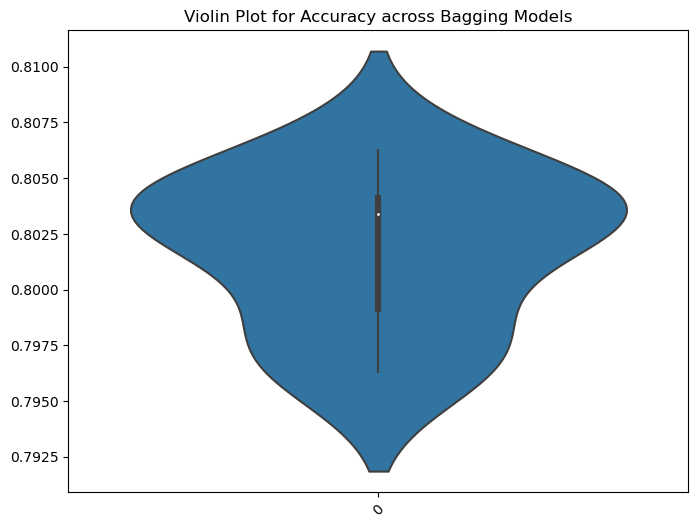

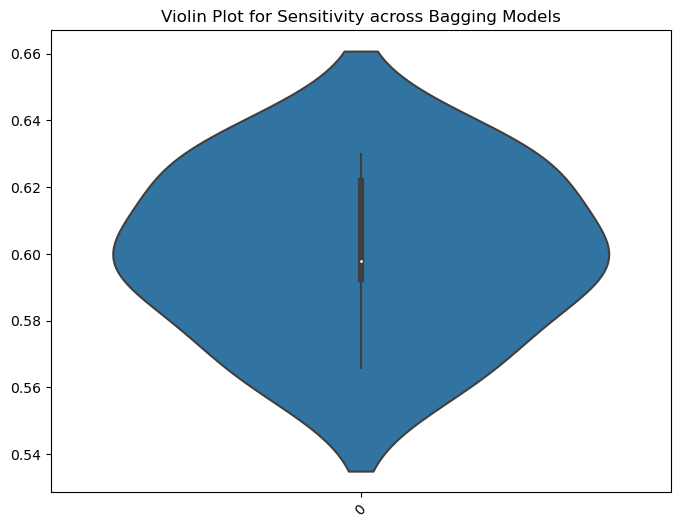

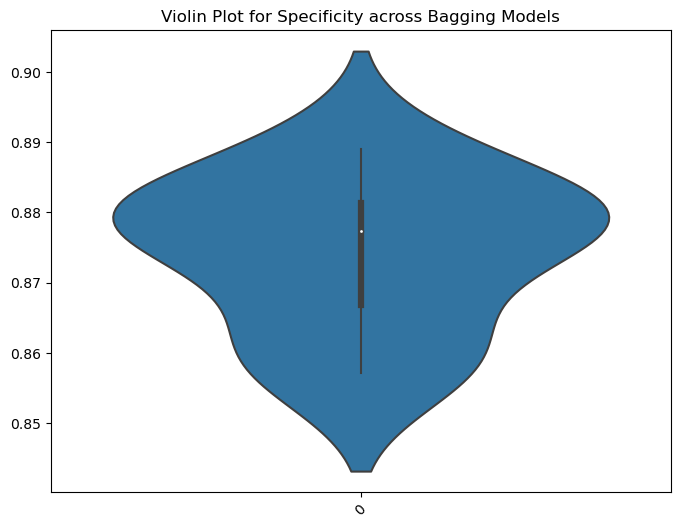

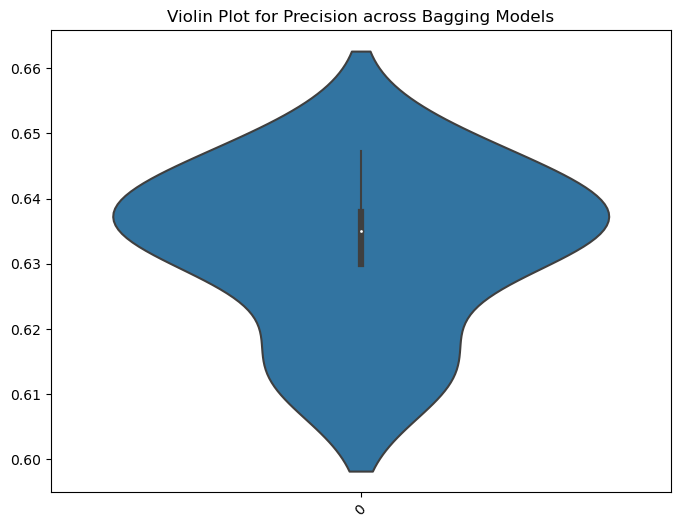

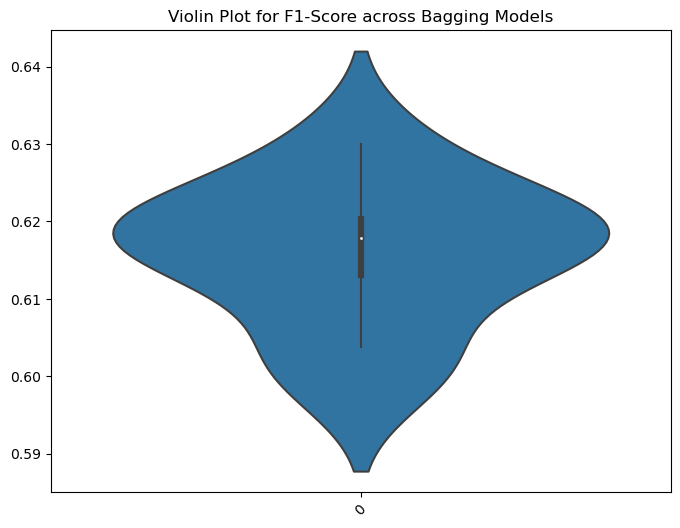

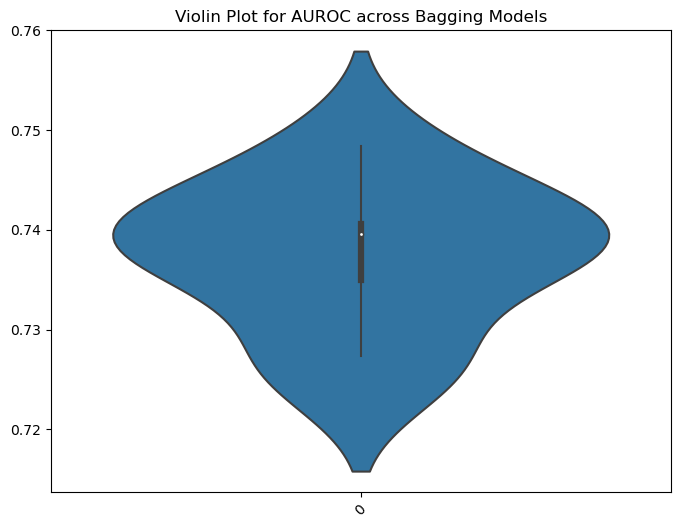

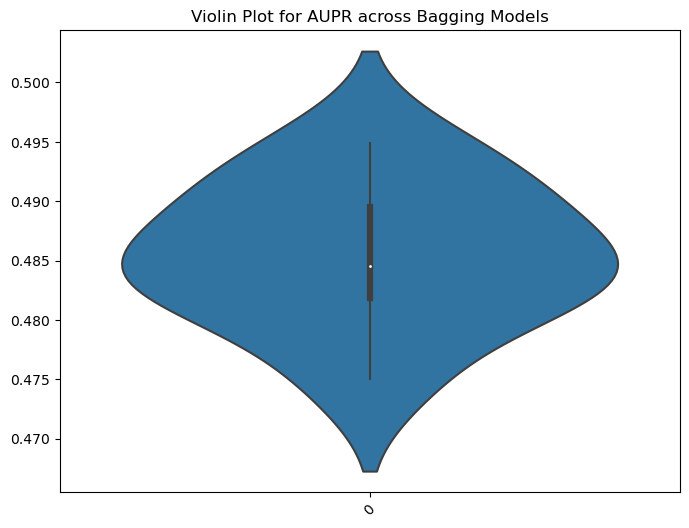

In [27]:
report_data = []

base_model = LogisticRegressionFromScratch(max_iter=1000)

bagging_model = BaggingLogisticRegression(base_model=base_model, n_estimators=9)


bagging_model.fit(X_train, Y_train)


test_predictions_col,Y_pred_bagging = bagging_model.predict(X_test)

all_metrics=[]
# Get predictions from all 9 models
test_predictions = bagging_model.predict_all(X_test)
for prediction in test_predictions:
    all_metrics.append(get_performance_metrics(Y_test, prediction))

all_metrics = np.array(all_metrics)
print(all_metrics.shape)

average_metrics = np.mean(all_metrics, axis=0)
std_metrics = np.std(all_metrics, axis=0)

metrics = get_performance_metrics(Y_test, Y_pred_bagging)
report_data.append(["LR*"] + list(average_metrics +  std_metrics))


print(f"Bagging Logistic Regression Accuracy: {average_metrics[0]:.2f} ± {std_metrics[0]:.2f}")
print(f"Bagging Logistic Regression Sensitivity: {average_metrics[1]:.2f} ± {std_metrics[1]:.2f}")
print(f"Bagging Logistic Regression Specificity: {average_metrics[2]:.2f} ± {std_metrics[2]:.2f}")
print(f"Bagging Logistic Regression Precision: {average_metrics[3]:.2f} ± {std_metrics[3]:.2f}")
print(f"Bagging Logistic Regression F1-Score: {average_metrics[4]:.2f} ± {std_metrics[4]:.2f}")
print(f"Bagging Logistic Regression AUROC: {average_metrics[5]:.2f} ± {std_metrics[5]:.2f}")
print(f"Bagging Logistic Regression AUPR: {average_metrics[6]:.2f} ± {std_metrics[6]:.2f}")



print(test_predictions_col.shape)
print(test_predictions.shape)


metrics = get_performance_metrics(Y_test, Y_pred_bagging)
report_data.append(["Voting ensemble"] + list(metrics))


print(f"Voting Ensemble Accuracy: {metrics[0]:.2f}")
print(f"Voting Ensemble Sensitivity: {metrics[1]:.2f}")
print(f"Voting Ensemble Specificity: {metrics[2]:.2f}")
print(f"Voting Ensemble Precision: {metrics[3]:.2f}")
print(f"Voting Ensemble F1-Score: {metrics[4]:.2f}")
print(f"Voting Ensemble AUROC: {metrics[5]:.2f}")
print(f"Voting Ensemble AUPR: {metrics[6]:.2f}")

validation_predictions_col,Y_val_pred = bagging_model.predict(X_val)
print(validation_predictions_col.shape)

if validation_predictions_col.ndim == 1:
    validation_predictions_col = validation_predictions_col.reshape(-1, 1)

# Concatenate X_val and validation_predictions_col along the columns
X_val_with_predictions = np.hstack((X_val, validation_predictions_col))
print(X_val_with_predictions.shape)


meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_val_with_predictions, Y_val)

X_test_with_predictions = np.hstack((X_test, test_predictions_col))
meta_predictions = meta_model.predict(X_test_with_predictions)


metrics = get_performance_metrics(Y_test, meta_predictions)
report_data.append(["Stacking ensemble"] + list(metrics))

print(f"Meta Model Accuracy: {metrics[0]:.2f}")
print(f"Meta Model Sensitivity: {metrics[1]:.2f}")
print(f"Meta Model Specificity: {metrics[2]:.2f}")
print(f"Meta Model Precision: {metrics[3]:.2f}")
print(f"Meta Model F1-Score: {metrics[4]:.2f}")
print(f"Meta Model AUROC: {metrics[5]:.2f}")
print(f"Meta Model AUPR: {metrics[6]:.2f}")


columns = ["Model", "Accuracy", "Sensitivity (Recall)", "Specificity", "Precision", "F1-Score", "AUROC", "AUPR"]
report_df = pd.DataFrame(report_data, columns=columns)

report_df.to_csv("performance_report.csv", index=False)
plot_violin(bagging_model.models, X_test, Y_test)

# Print predictions from all 9 models
# print("Predictions from all 9 models:")
# print(test_predictions)

In [32]:


def preprocessor_dataset2(dataframe, target_col):
    # dataframe = pd.read_csv(data_path)

    for col in dataframe.columns:
        if dataframe[col].dtype == 'object':
            dataframe[col] = dataframe[col].str.strip()  # Trim leading and trailing spaces
            dataframe[col].replace('', np.nan, inplace=True)  # Replace empty strings with NaN

    for col in dataframe.columns:
        try:
            dataframe[col] = pd.to_numeric(dataframe[col])
        except ValueError:
            pass 

    dataframe.drop_duplicates(inplace=True)  # drop duplicates 
    dataframe.dropna(subset=[target_col], inplace=True)  # drop missing values of target column
    

    features = dataframe.drop(target_col, axis=1)
    target = dataframe[target_col]

    for col in features.columns:
        if features[col].dtype == 'object':
            features[col].fillna(features[col].mode()[0], inplace=True)
        else:
            features[col].fillna(features[col].mean(), inplace=True)
    
    if target.nunique() == 2:
        encoder = LabelEncoder()
        target = encoder.fit_transform(target)
    else:
        # one hot encoding
        target = pd.get_dummies(target, columns=[0])

    catagorical_cols = []
    boolean_cols = []

    for col in features.columns:
        if features[col].nunique() == 2:
            boolean_cols.append(col)
            encoder = LabelEncoder()
            features[col] = encoder.fit_transform(features[col])
        else:
            if features[col].dtype == 'object':
                catagorical_cols.append(col)
                features[col] = features[col].astype('category')

    features = pd.get_dummies(features, columns=catagorical_cols)
    
    scaling_cols = features.columns.difference(catagorical_cols)
    scaling_cols = scaling_cols.difference(boolean_cols)    

    # features = scale_min_max_features(features, scaling_cols)
    features = scale_standard_features(features, scaling_cols)
    target_copy = pd.DataFrame(target, columns=[target_col])
  
    features_copy = features.copy()
    features_copy[target_col] = target_copy[target_col]
    correlafeatures_copy = features_copy.corr()

    corr_with_target = correlafeatures_copy[target_col].drop(target_col).abs()
    
    # # Select the top 20 features with the highest absolute correlation
    top_20_features = corr_with_target.abs().sort_values(ascending=False).head(20).index
    features = features[top_20_features]


    X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    return X_train.to_numpy(), X_test.to_numpy(), Y_train, Y_test
    # return X_train, X_test, Y_train, Y_test

# X_train, X_test, Y_train, Y_test = preprocessor("creditcard.csv", 'Class')

df_train = pd.read_csv("adult/adult.data", header=None)
df_test = pd.read_csv("adult/adult.test", header=None, skiprows=1)

print(df_train.shape)
print(df_test.shape)


# print(df_train.dtypes)

for col in df_train.columns:
    if df_train[col].dtype == 'object':
        df_train[col] = df_train[col].str.strip()  # Trim leading and trailing spaces
        df_train[col].replace('?', np.nan, inplace=True)

for col in df_test.columns:
    if df_test[col].dtype == 'object':
        df_test[col] = df_test[col].str.strip()  # Trim leading and trailing spaces
        df_test[col].replace('?', np.nan, inplace=True)

df_train[14] = df_train[14].str.strip().str.replace(".", "")
df_test[14] = df_test[14].str.strip().str.replace(".", "")

for col in df_train.columns:
    try:
        df_train[col] = pd.to_numeric(df_train[col])
    except ValueError:
        pass 

for col in df_test.columns:
    try:
        df_test[col] = pd.to_numeric(df_test[col])
    except ValueError:
        pass 

dataframe=pd.concat([df_train, df_test], axis=0)
print(dataframe.shape)
print(dataframe.columns)


X_train, X_test, Y_train, Y_test = preprocessor_dataset2(dataframe, 14)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print(X_test.shape)
print(Y_test.shape)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)


(32561, 15)
(16281, 15)
(48842, 15)
Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64')
(9758, 20)
(9758,)
(31225, 20)
(31225,)
(7807, 20)
(7807,)


(9, 7)
Bagging Logistic Regression Accuracy: 0.83 ± 0.00
Bagging Logistic Regression Sensitivity: 0.56 ± 0.00
Bagging Logistic Regression Specificity: 0.92 ± 0.00
Bagging Logistic Regression Precision: 0.70 ± 0.00
Bagging Logistic Regression F1-Score: 0.62 ± 0.00
Bagging Logistic Regression AUROC: 0.74 ± 0.00
Bagging Logistic Regression AUPR: 0.50 ± 0.00
(9758, 9)
(9, 9758)
Voting Ensemble Accuracy: 0.83
Voting Ensemble Sensitivity: 0.56
Voting Ensemble Specificity: 0.92
Voting Ensemble Precision: 0.70
Voting Ensemble F1-Score: 0.62
Voting Ensemble AUROC: 0.74
Voting Ensemble AUPR: 0.50
(7807, 9)
(7807, 29)
Meta Model Accuracy: 0.84
Meta Model Sensitivity: 0.59
Meta Model Specificity: 0.93
Meta Model Precision: 0.72
Meta Model F1-Score: 0.65
Meta Model AUROC: 0.76
Meta Model AUPR: 0.53


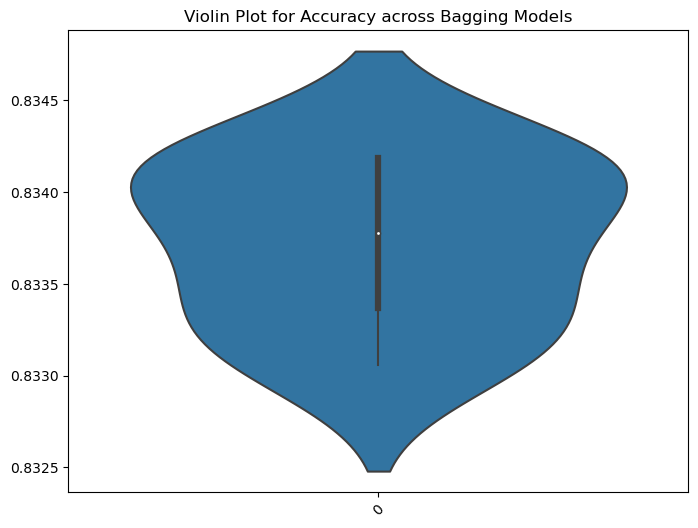

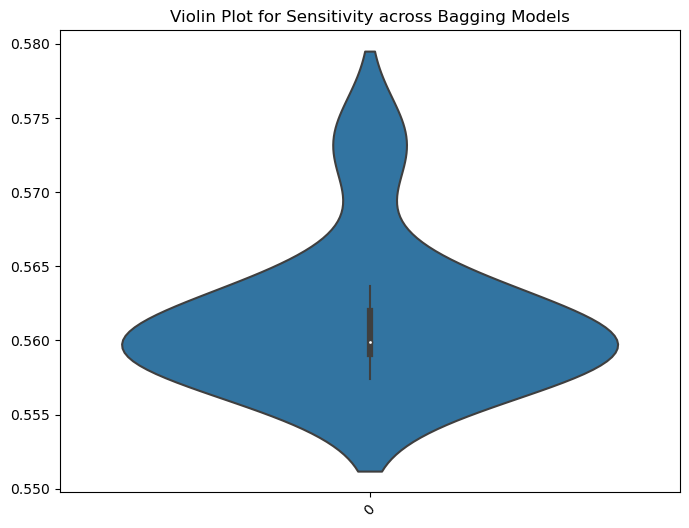

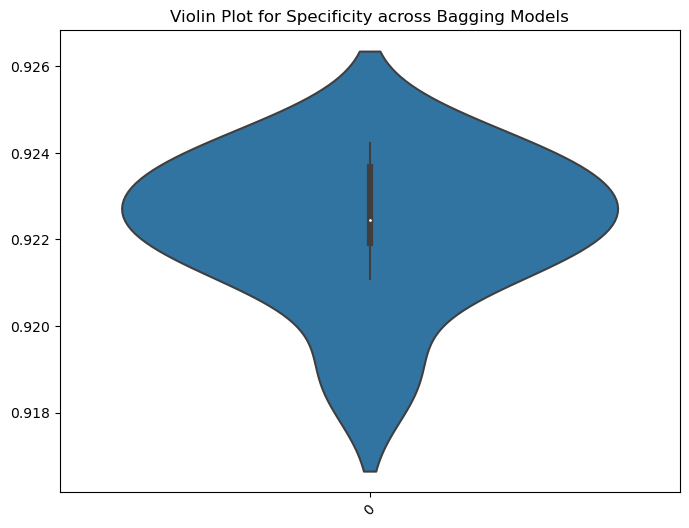

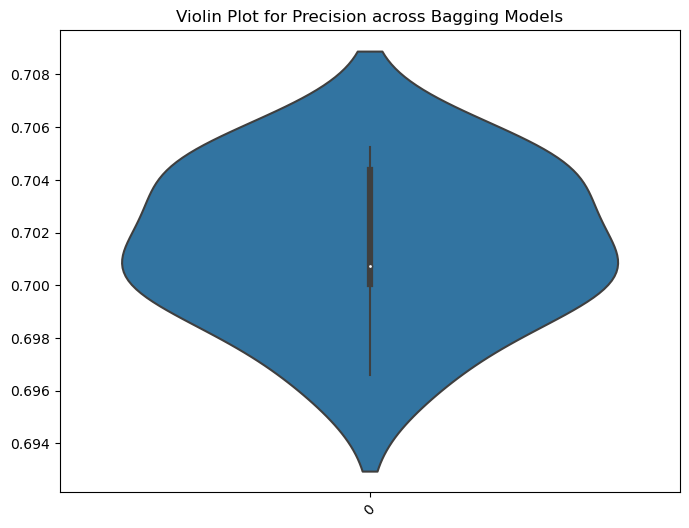

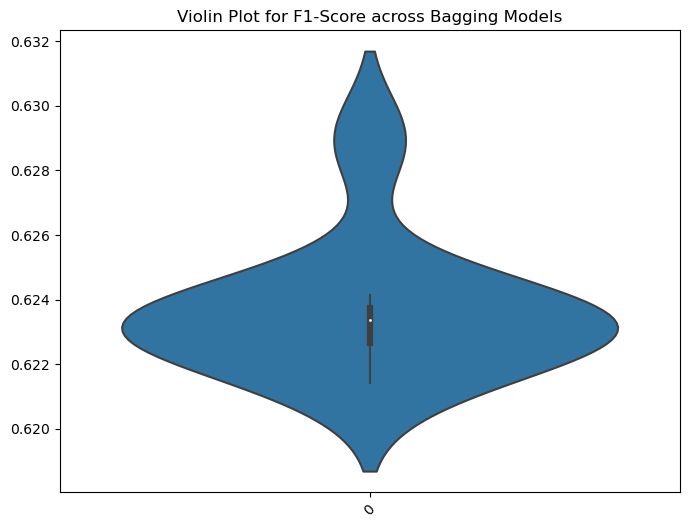

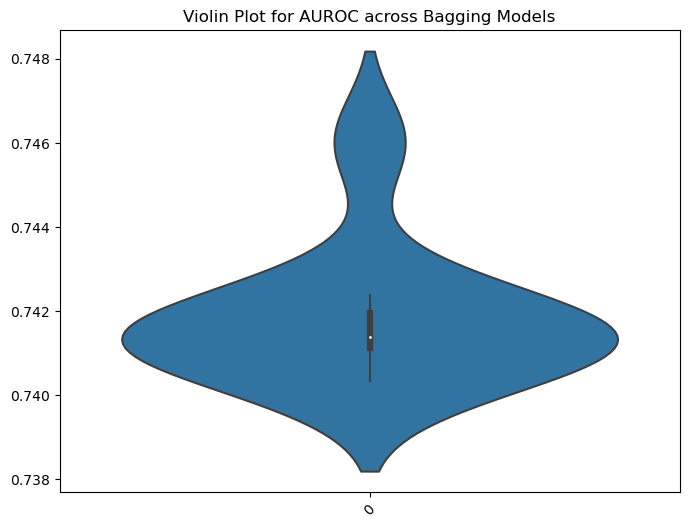

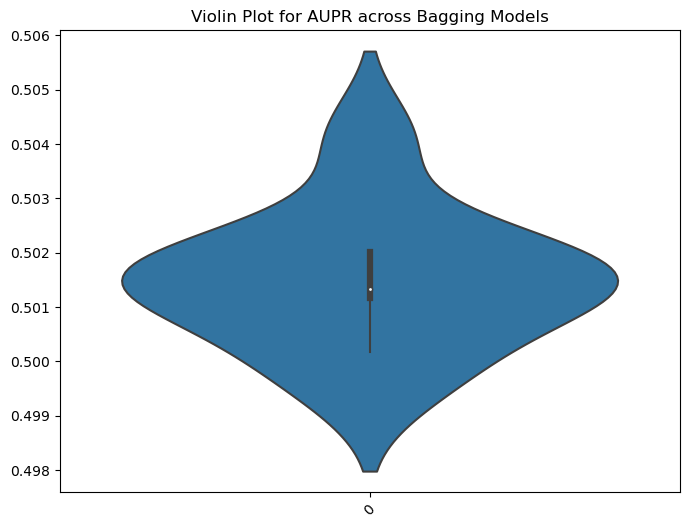

In [33]:
report_data = []

base_model = LogisticRegressionFromScratch(max_iter=1000)

bagging_model = BaggingLogisticRegression(base_model=base_model, n_estimators=9)


bagging_model.fit(X_train, Y_train)


test_predictions_col,Y_pred_bagging = bagging_model.predict(X_test)

all_metrics=[]
# Get predictions from all 9 models
test_predictions = bagging_model.predict_all(X_test)
for prediction in test_predictions:
    all_metrics.append(get_performance_metrics(Y_test, prediction))

all_metrics = np.array(all_metrics)
print(all_metrics.shape)

average_metrics = np.mean(all_metrics, axis=0)
std_metrics = np.std(all_metrics, axis=0)

metrics = get_performance_metrics(Y_test, Y_pred_bagging)
report_data.append(["LR*"] + list(average_metrics +  std_metrics))


print(f"Bagging Logistic Regression Accuracy: {average_metrics[0]:.2f} ± {std_metrics[0]:.2f}")
print(f"Bagging Logistic Regression Sensitivity: {average_metrics[1]:.2f} ± {std_metrics[1]:.2f}")
print(f"Bagging Logistic Regression Specificity: {average_metrics[2]:.2f} ± {std_metrics[2]:.2f}")
print(f"Bagging Logistic Regression Precision: {average_metrics[3]:.2f} ± {std_metrics[3]:.2f}")
print(f"Bagging Logistic Regression F1-Score: {average_metrics[4]:.2f} ± {std_metrics[4]:.2f}")
print(f"Bagging Logistic Regression AUROC: {average_metrics[5]:.2f} ± {std_metrics[5]:.2f}")
print(f"Bagging Logistic Regression AUPR: {average_metrics[6]:.2f} ± {std_metrics[6]:.2f}")



print(test_predictions_col.shape)
print(test_predictions.shape)


metrics = get_performance_metrics(Y_test, Y_pred_bagging)
report_data.append(["Voting ensemble"] + list(metrics))


print(f"Voting Ensemble Accuracy: {metrics[0]:.2f}")
print(f"Voting Ensemble Sensitivity: {metrics[1]:.2f}")
print(f"Voting Ensemble Specificity: {metrics[2]:.2f}")
print(f"Voting Ensemble Precision: {metrics[3]:.2f}")
print(f"Voting Ensemble F1-Score: {metrics[4]:.2f}")
print(f"Voting Ensemble AUROC: {metrics[5]:.2f}")
print(f"Voting Ensemble AUPR: {metrics[6]:.2f}")

validation_predictions_col,Y_val_pred = bagging_model.predict(X_val)
print(validation_predictions_col.shape)

if validation_predictions_col.ndim == 1:
    validation_predictions_col = validation_predictions_col.reshape(-1, 1)

# Concatenate X_val and validation_predictions_col along the columns
X_val_with_predictions = np.hstack((X_val, validation_predictions_col))
print(X_val_with_predictions.shape)


meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_val_with_predictions, Y_val)

X_test_with_predictions = np.hstack((X_test, test_predictions_col))
meta_predictions = meta_model.predict(X_test_with_predictions)


metrics = get_performance_metrics(Y_test, meta_predictions)
report_data.append(["Stacking ensemble"] + list(metrics))

print(f"Meta Model Accuracy: {metrics[0]:.2f}")
print(f"Meta Model Sensitivity: {metrics[1]:.2f}")
print(f"Meta Model Specificity: {metrics[2]:.2f}")
print(f"Meta Model Precision: {metrics[3]:.2f}")
print(f"Meta Model F1-Score: {metrics[4]:.2f}")
print(f"Meta Model AUROC: {metrics[5]:.2f}")
print(f"Meta Model AUPR: {metrics[6]:.2f}")


columns = ["Model", "Accuracy", "Sensitivity (Recall)", "Specificity", "Precision", "F1-Score", "AUROC", "AUPR"]
report_df = pd.DataFrame(report_data, columns=columns)

report_df.to_csv("performance_report.csv", index=False)
plot_violin(bagging_model.models, X_test, Y_test)

# Print predictions from all 9 models
# print("Predictions from all 9 models:")
# print(test_predictions)

In [21]:


def preprocessor_dataset3(data_path, target_col):
    dataframe = pd.read_csv(data_path)
    for col in dataframe.columns:
        if dataframe[col].dtype == 'object':
            dataframe[col] = dataframe[col].str.strip()  # Trim leading and trailing spaces
            dataframe[col].replace('', np.nan, inplace=True)  # Replace empty strings with NaN

    for col in dataframe.columns:
        try:
            dataframe[col] = pd.to_numeric(dataframe[col])
        except ValueError:
            pass 

    dataframe.drop_duplicates(inplace=True)  # drop duplicates 
    dataframe.dropna(subset=[target_col], inplace=True)  # drop missing values of target column
    
    
    positive_samples = dataframe[dataframe['Class'] == 1]
    negative_samples = dataframe[dataframe['Class'] == 0]

    # Sample 20,000 negative samples
    negative_samples_sampled = negative_samples.sample(n=20000, random_state=42)

    # Combine the sampled negative samples with all positive samples
    dataframe = pd.concat([positive_samples, negative_samples_sampled])

    # Shuffle the combined data
    dataframe = dataframe.sample(frac=1, random_state=42).reset_index(drop=True)

    # Print the shape of the balanced data to verify
    print(dataframe.shape)

    features = dataframe.drop(target_col, axis=1)
    target = dataframe[target_col]

    for col in features.columns:
        if features[col].dtype == 'object':
            features[col].fillna(features[col].mode()[0], inplace=True)
        else:
            features[col].fillna(features[col].mean(), inplace=True)
    
    if target.nunique() == 2:
        encoder = LabelEncoder()
        target = encoder.fit_transform(target)
    else:
        # one hot encoding
        target = pd.get_dummies(target, columns=[target_col])

    catagorical_cols = []
    boolean_cols = []

    for col in features.columns:
        if col == 'customerID':
            features.drop(col, axis=1, inplace=True)  # drop customerID column
            continue 
        if features[col].nunique() == 2:
            boolean_cols.append(col)
            encoder = LabelEncoder()
            features[col] = encoder.fit_transform(features[col])
        else:
            if features[col].dtype == 'object':
                catagorical_cols.append(col)
                features[col] = features[col].astype('category')

    features = pd.get_dummies(features, columns=catagorical_cols)
    
    scaling_cols = features.columns.difference(catagorical_cols)
    scaling_cols = scaling_cols.difference(boolean_cols)    

    # features = scale_min_max_features(features, scaling_cols)
    scale_standard_features(features, scaling_cols)

    correlation_matrix = pd.concat([features, pd.Series(target, name=target_col)], axis=1).corr()
    
    # Get the correlation with the target column
    corr_with_target = correlation_matrix[target_col].drop(target_col).abs()
    
    # Select the top 20 features with the highest absolute correlation
    top_20_features = corr_with_target.abs().sort_values(ascending=False).head(20).index
    features = features[top_20_features]

    X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    return X_train.to_numpy(), X_test.to_numpy(), Y_train, Y_test
    # return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = preprocessor_dataset3("creditcard.csv", 'Class')
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print(X_test)
print(Y_test.shape)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)


(20473, 31)
[[ 0.90434346  0.27235141 -0.28087667 ...  0.29138344 -0.43548568
  -0.99513672]
 [ 0.52412192  0.05970969  0.71748367 ... -0.18600321 -0.515356
  -0.06477684]
 [ 0.53022787  0.83969585  0.15368872 ... -0.07774937 -0.38982888
  -0.31336491]
 ...
 [ 1.11310619 -2.16482146  0.20957093 ... -0.56299162 -0.0855103
  -0.61604723]
 [ 0.13989585 -0.21469568 -0.24394851 ...  0.19427516  0.11174227
   0.34528301]
 [ 0.31200941 -0.39566122  0.06365885 ... -0.32413437 -0.35601283
   0.72316001]]
(4095,)
(13102, 20)
(13102,)
(3276, 20)
(3276,)


(9, 7)
Bagging Logistic Regression Accuracy: 0.99 ± 0.00
Bagging Logistic Regression Sensitivity: 0.77 ± 0.00
Bagging Logistic Regression Specificity: 1.00 ± 0.00
Bagging Logistic Regression Precision: 1.00 ± 0.00
Bagging Logistic Regression F1-Score: 0.87 ± 0.00
Bagging Logistic Regression AUROC: 0.89 ± 0.00
Bagging Logistic Regression AUPR: 0.78 ± 0.00
(4095, 9)
(9, 4095)
Voting Ensemble Accuracy: 0.99
Voting Ensemble Sensitivity: 0.77
Voting Ensemble Specificity: 1.00
Voting Ensemble Precision: 1.00
Voting Ensemble F1-Score: 0.87
Voting Ensemble AUROC: 0.89
Voting Ensemble AUPR: 0.78
(3276, 9)
(3276, 29)
Meta Model Accuracy: 0.99
Meta Model Sensitivity: 0.79
Meta Model Specificity: 1.00
Meta Model Precision: 0.97
Meta Model F1-Score: 0.87
Meta Model AUROC: 0.89
Meta Model AUPR: 0.77


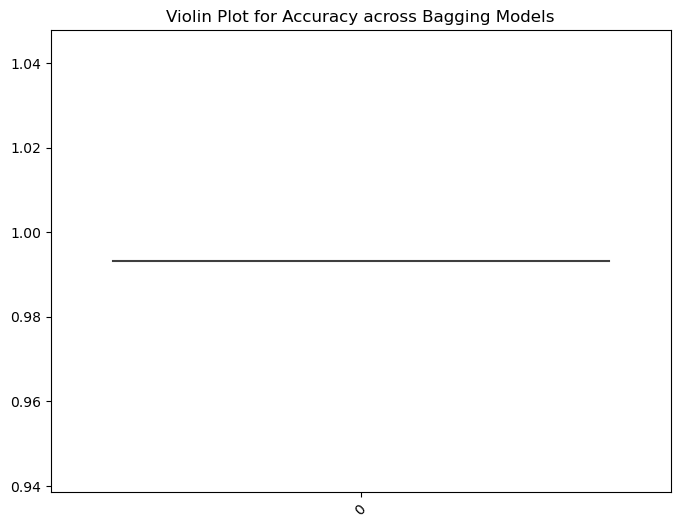

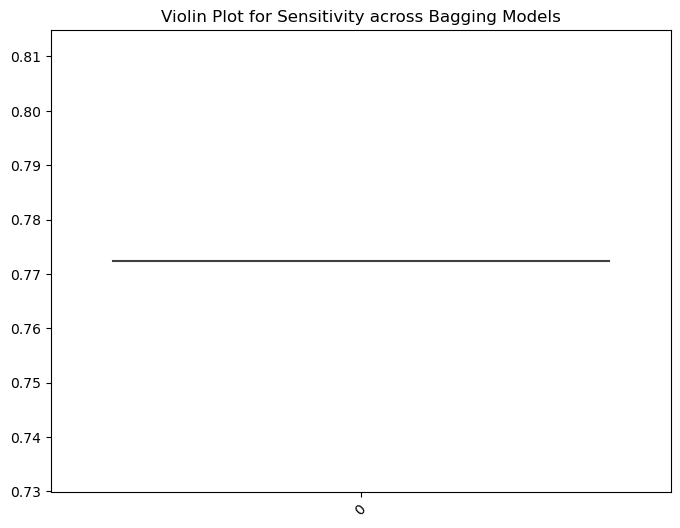

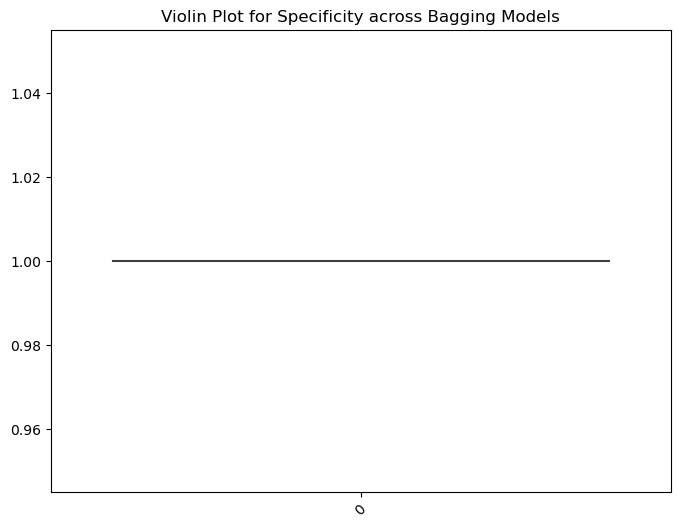

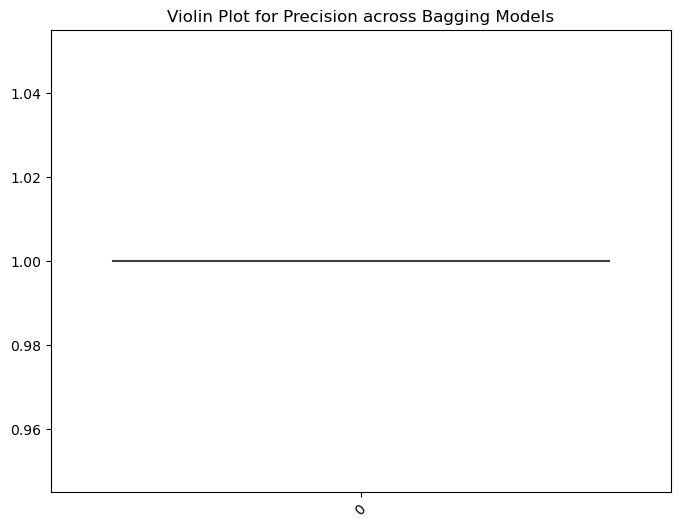

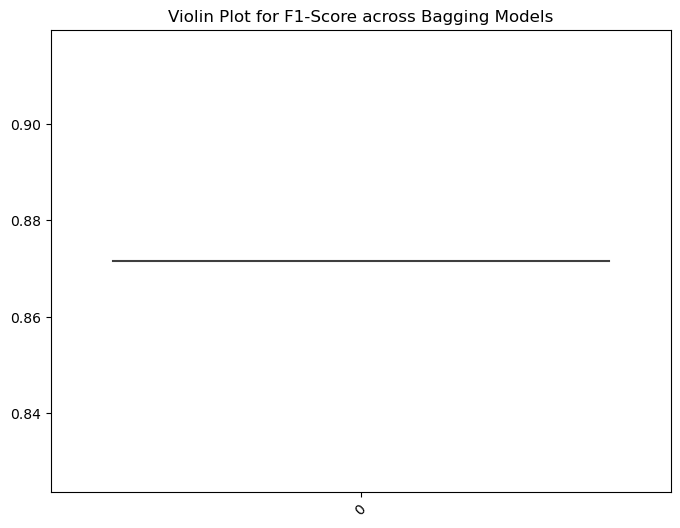

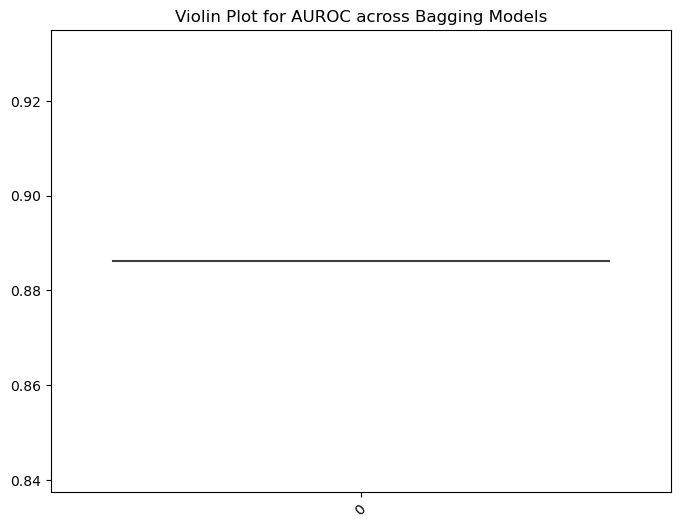

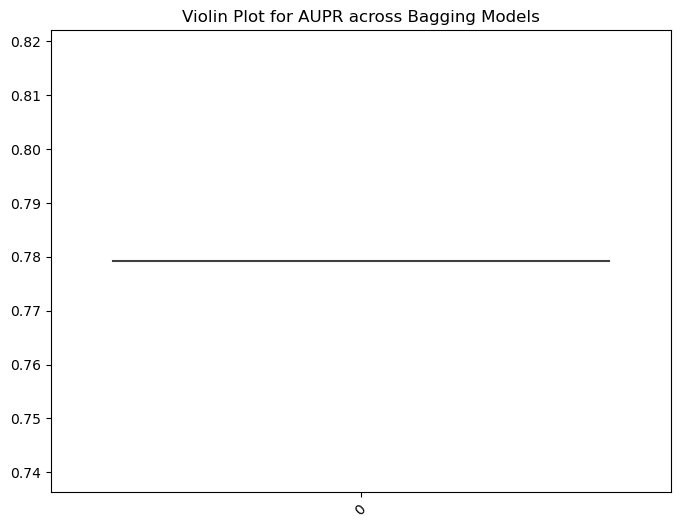

In [22]:
report_data = []

base_model = LogisticRegressionFromScratch(max_iter=1000)

bagging_model = BaggingLogisticRegression(base_model=base_model, n_estimators=9)


bagging_model.fit(X_train, Y_train)


test_predictions_col,Y_pred_bagging = bagging_model.predict(X_test)

all_metrics=[]
# Get predictions from all 9 models
test_predictions = bagging_model.predict_all(X_test)
for prediction in test_predictions:
    all_metrics.append(get_performance_metrics(Y_test, prediction))

all_metrics = np.array(all_metrics)
print(all_metrics.shape)

average_metrics = np.mean(all_metrics, axis=0)
std_metrics = np.std(all_metrics, axis=0)

metrics = get_performance_metrics(Y_test, Y_pred_bagging)
report_data.append(["LR*"] + list(average_metrics +  std_metrics))


print(f"Bagging Logistic Regression Accuracy: {average_metrics[0]:.2f} ± {std_metrics[0]:.2f}")
print(f"Bagging Logistic Regression Sensitivity: {average_metrics[1]:.2f} ± {std_metrics[1]:.2f}")
print(f"Bagging Logistic Regression Specificity: {average_metrics[2]:.2f} ± {std_metrics[2]:.2f}")
print(f"Bagging Logistic Regression Precision: {average_metrics[3]:.2f} ± {std_metrics[3]:.2f}")
print(f"Bagging Logistic Regression F1-Score: {average_metrics[4]:.2f} ± {std_metrics[4]:.2f}")
print(f"Bagging Logistic Regression AUROC: {average_metrics[5]:.2f} ± {std_metrics[5]:.2f}")
print(f"Bagging Logistic Regression AUPR: {average_metrics[6]:.2f} ± {std_metrics[6]:.2f}")



print(test_predictions_col.shape)
print(test_predictions.shape)


metrics = get_performance_metrics(Y_test, Y_pred_bagging)
report_data.append(["Voting ensemble"] + list(metrics))


print(f"Voting Ensemble Accuracy: {metrics[0]:.2f}")
print(f"Voting Ensemble Sensitivity: {metrics[1]:.2f}")
print(f"Voting Ensemble Specificity: {metrics[2]:.2f}")
print(f"Voting Ensemble Precision: {metrics[3]:.2f}")
print(f"Voting Ensemble F1-Score: {metrics[4]:.2f}")
print(f"Voting Ensemble AUROC: {metrics[5]:.2f}")
print(f"Voting Ensemble AUPR: {metrics[6]:.2f}")

validation_predictions_col,Y_val_pred = bagging_model.predict(X_val)
print(validation_predictions_col.shape)

if validation_predictions_col.ndim == 1:
    validation_predictions_col = validation_predictions_col.reshape(-1, 1)

# Concatenate X_val and validation_predictions_col along the columns
X_val_with_predictions = np.hstack((X_val, validation_predictions_col))
print(X_val_with_predictions.shape)


meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_val_with_predictions, Y_val)

X_test_with_predictions = np.hstack((X_test, test_predictions_col))
meta_predictions = meta_model.predict(X_test_with_predictions)


metrics = get_performance_metrics(Y_test, meta_predictions)
report_data.append(["Stacking ensemble"] + list(metrics))

print(f"Meta Model Accuracy: {metrics[0]:.2f}")
print(f"Meta Model Sensitivity: {metrics[1]:.2f}")
print(f"Meta Model Specificity: {metrics[2]:.2f}")
print(f"Meta Model Precision: {metrics[3]:.2f}")
print(f"Meta Model F1-Score: {metrics[4]:.2f}")
print(f"Meta Model AUROC: {metrics[5]:.2f}")
print(f"Meta Model AUPR: {metrics[6]:.2f}")


columns = ["Model", "Accuracy", "Sensitivity (Recall)", "Specificity", "Precision", "F1-Score", "AUROC", "AUPR"]
report_df = pd.DataFrame(report_data, columns=columns)

report_df.to_csv("performance_report.csv", index=False)
plot_violin(bagging_model.models, X_test, Y_test)

# Print predictions from all 9 models
# print("Predictions from all 9 models:")
# print(test_predictions)